In [1]:
import os
import numpy as np
import pandas as pd

import ivfunctions_nested 
import mliv.dgps_nested as dgps
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.cluster import KMeans
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import AGMM, AGMM2, AGMM2L2
from mliv.tsls import tsls, regtsls

p = 0.1  # dropout prob of dropout layers throughout notebook
n_hidden = 100  # width of hidden layers throughout notebook


device = torch.cuda.current_device() if torch.cuda.is_available() else None

In [2]:
fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)

In [3]:
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)


B_test = np.zeros((1000, B.shape[1]))
B_test += np.median(B, axis=0, keepdims=True)
B_test[:, 0] = np.linspace(np.percentile(B[:, 0], 5), np.percentile(B[:, 0], 95), 1000)

B_test = B_test[np.argsort(B_test[:, 0])]
true_fn = tau_fn(B_test)


In [4]:
A_test = np.zeros((1000, A.shape[1]))
A_test += np.median(A, axis=0, keepdims=True)
A_test[:, 0] = np.linspace(np.percentile(A[:, 0], 5), np.percentile(A[:, 0], 95), 1000)

A_test = A_test[np.argsort(A_test[:, 0])]
true_fn_A = A_test[:, 0]

In [5]:
def nested_npivfit(A, B, C, D, Y, B_test, A_test, model1, model2):

    B1_test = torch.Tensor(B_test)
    if A_test is not None:
        A1_test = torch.Tensor(A_test)
    Y = torch.Tensor(Y)
    A1 = torch.Tensor(A)
    B1 = torch.Tensor(B)
    A2 = torch.Tensor(D)
    B2 = torch.Tensor(C)

    #First stage
    m1 = model1.fit(A2, A1, Y, n_epochs=150)
    bridge_fs = torch.Tensor(m1.predict(A1.to(device)))
    
    #Second stage
    m2 = model2.fit(B2, B1, bridge_fs,n_epochs=150)
    y_pred = m2.predict(B1_test.to(device))
    

    return y_pred.reshape(B1_test.shape[:1] + Y.shape[1:]), m1.predict(A1_test.to(device)).reshape(A1_test.shape[:1] + Y.shape[1:])





In [6]:
def _get_learner(n_t):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))



In [7]:
agmm_1 = AGMM(_get_learner(A.shape[1]),_get_adversary(D.shape[1]))
agmm_2 = AGMM(_get_learner(B.shape[1]),_get_adversary(C.shape[1]))

In [8]:

agmm_pred, agmm_pred_g = nested_npivfit(A, B, C, D, Y, B_test, A_test, model1=agmm_1, model2=agmm_2)
 

In [9]:
n_hidden = 100  # width of hidden layers throughout notebook

agmm2_model = AGMM2(learnerh = _get_learner(B.shape[1]), learnerg = _get_learner(A.shape[1]),
                     adversary1 = _get_adversary(D.shape[1]), adversary2 = _get_adversary(C.shape[1]))


A = torch.tensor(A, dtype=torch.float32)
D = torch.tensor(D, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
C = torch.tensor(C, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
B_test = torch.tensor(B_test, dtype=torch.float32)
A_test = torch.tensor(A_test, dtype=torch.float32)
agmm2_pred,agmm2_pred_g = agmm2_model.fit(A, B, C, D, Y, n_epochs=300).predict(B_test.to(device), A_test.to(device))

In [10]:
n_hidden = 100  # width of hidden layers throughout notebook

agmm2l2_model = AGMM2L2(learnerh = _get_learner(B.shape[1]), learnerg = _get_learner(A.shape[1]),
                     adversary1 = _get_adversary(D.shape[1]), adversary2 = _get_adversary(C.shape[1]))


A = A.clone().detach().float()
D = D.clone().detach().float()
B = B.clone().detach().float()
C = C.clone().detach().float()
Y = Y.clone().detach().float()
B_test = B_test.clone().detach().float()
A_test = A_test.clone().detach().float()
agmm2l2_pred,agmm2l2_pred_g = agmm2_model.fit(A, B, C, D, Y, n_epochs=300).predict(B_test.to(device), A_test.to(device))

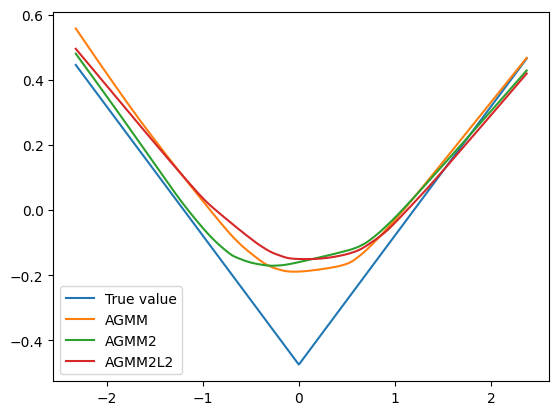

In [11]:
plt.plot(B_test[:, 0], true_fn, label='True value')
plt.plot(B_test[:, 0], agmm_pred, label='AGMM')
plt.plot(B_test[:, 0], agmm2_pred, label='AGMM2')
plt.plot(B_test[:, 0], agmm2l2_pred, label='AGMM2L2')
plt.legend()


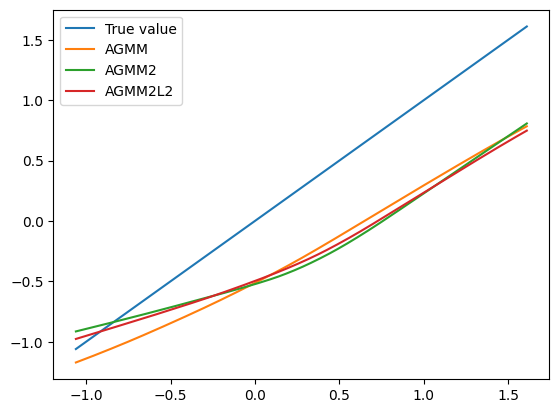

In [12]:
plt.plot(A_test[:, 0], true_fn_A, label='True value')
plt.plot(A_test[:, 0], agmm_pred_g, label='AGMM')
plt.plot(A_test[:, 0], agmm2_pred_g, label='AGMM2')
plt.plot(A_test[:, 0], agmm2l2_pred_g, label='AGMM2L2')
plt.legend()